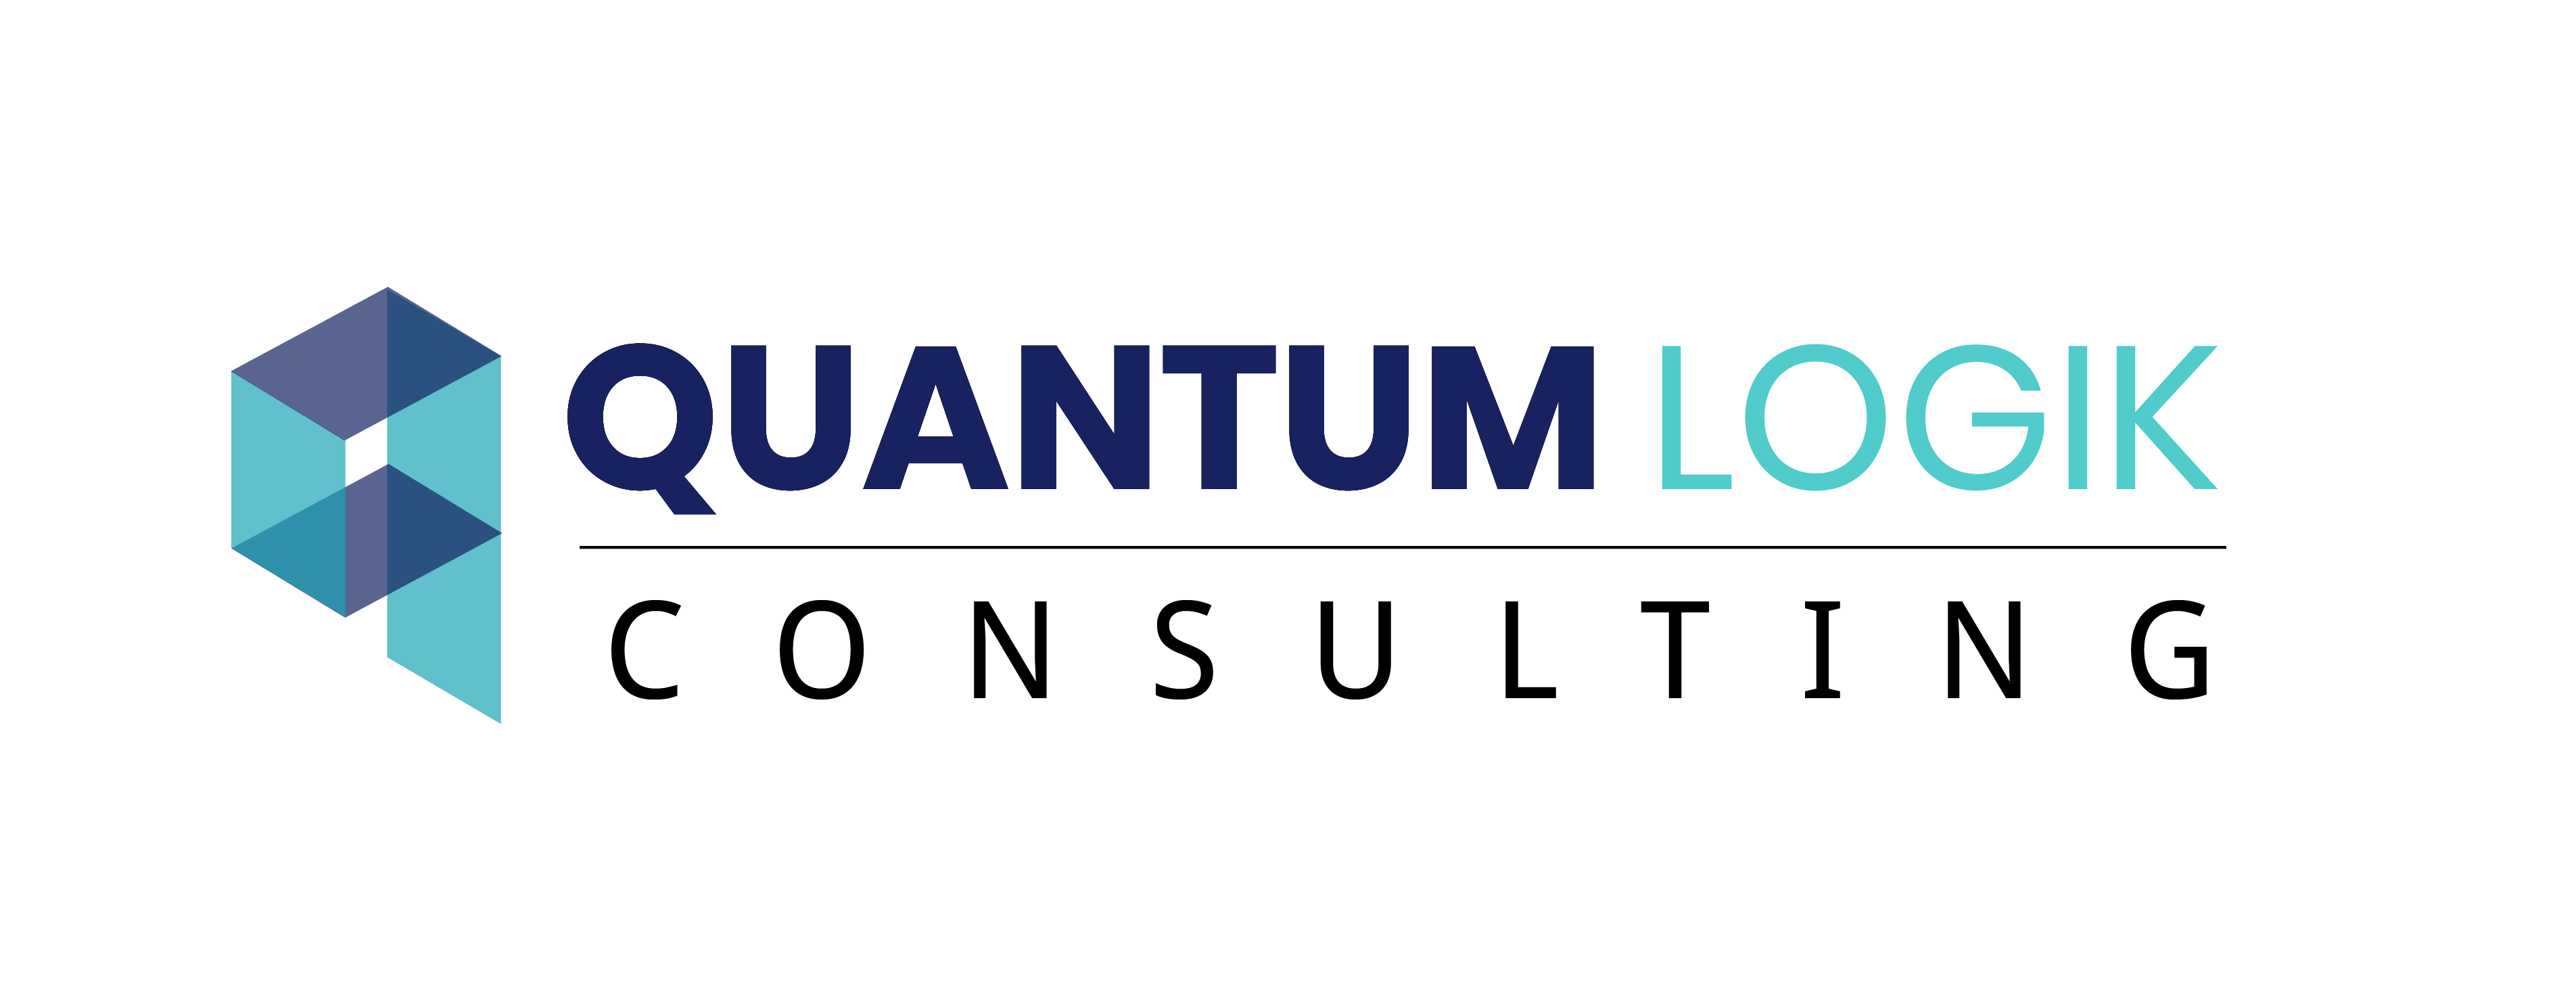

Please see the Readme for the complete motivation

# 1.0 Introduction

## 1.1 Credits, Sources, and Inspirations


- **S-Curve Analytical Framework**

 - The Partners and Associates of [Quantum Logik Consulting](https://quantumlogik.com/)
 - (former consultants at [The Economist Intelligence Unit](https://www.eiu.com/) )


- **Beverages perspective** 

 - [Quantum Logik Blog Post](https://quantumlogik.com/2021/05/28/qlc-perspectives-the-five-existential-challenges-to-global-beverages/)


- **Inspiration for the Bokeh Visualization**

 - https://www.geeksforgeeks.org/python-bokeh-plotting-a-scatter-plot-on-a-graph/
 - https://github.com/WillKoehrsen/Bokeh-Python-Visualization/blob/master/interactive/exploration/delay_histogram.py


- **Data**

 - https://www.who.int/data/gho/info/gho-odata-api
 - http://api.worldbank.org/v2/country/all/indicator/SP.POP.TOTL


- **[Country Conversion Library]**(https://nbviewer.jupyter.org/github/konstantinstadler/country_converter/blob/master/doc/country_converter_examples.ipynb)

 - Konstantin Stadler


- **Author(s)**
 - [Jon Mayes](https://github.com/yfMayes)

## 1.2 One liner

Using api access to open data to see if any macro trends can tell us about global beer company performance at a strategic level

Please see readme for more details

# 2.0 Imports and Installations

## 2.1 Import Analytical and JSON libraries

In [1]:
#The basics
import pandas as pd
import numpy as np

#To handle the api json requests
import requests as r
import json
import time

## 2.2 (Optional) Install jupyter notebook extensions 

In [2]:
#uncomment to run
#import sys 
#!{sys.executable} -m pip install jupyter_contrib_nbextensions --upgrade

In [3]:
#uncomment to run
#!jupyter contrib nbextension install --system

## 2.3 Install and import Country Converter (CoCo)

Notes:
Unfortunately, I couldn't find an easy World Bank geographical grouping. They do it mostly by income and development. 
To keep with theme of open data, I had to use UN regions.
WB and UN don't easily speak to each other so this library made it much easier
And it gives us a chance to do some light data engineering

https://nbviewer.jupyter.org/github/konstantinstadler/country_converter/blob/master/doc/country_converter_examples.ipynb


#note, he's got a pretty decent regex capability with this as well. please see his github repo for more details

In [4]:
#uncomment to run
#import sys
#!{sys.executable} -m pip install country_converter

In [5]:
import country_converter as coco
converter = coco.CountryConverter()


In [6]:
converter.data

,APEC,BASIC,BRIC,CIS,Cecilia2050,EEA,EU,EU12,EU15,EU25,...,UN,UNcode,UNmember,UNregion,WIOD,continent,name_official,name_short,obsolete,regex
0,NaN,NaN,NaN,NaN,RoW,NaN,NaN,NaN,NaN,NaN,...,1946.0,4.0,1946.0,Southern Asia,RoW,Asia,Islamic Republic of Afghanistan,Afghanistan,NaN,afghan
1,NaN,NaN,NaN,NaN,RoW,NaN,NaN,NaN,NaN,NaN,...,NaN,248.0,NaN,Northern Europe,RoW,Europe,Åland Islands,Aland Islands,NaN,\b(a|å)land
2,NaN,NaN,NaN,NaN,RoW,NaN,NaN,NaN,NaN,NaN,...,1955.0,8.0,1955.0,Southern Europe,RoW,Europe,Republic of Albania,Albania,NaN,albania
3,NaN,NaN,NaN,NaN,RoW,NaN,NaN,NaN,NaN,NaN,...,1962.0,12.0,1962.0,Northern Africa,RoW,Africa,People's Democratic Republic of Algeria,Algeria,NaN,algeria
4,NaN,NaN,NaN,NaN,RoW,NaN,NaN,NaN,NaN,NaN,...,NaN,16.0,NaN,Polynesia,RoW,Oceania,American Samoa,American Samoa,NaN,^(?=.*americ).*samoa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,NaN,NaN,NaN,NaN,RoW,NaN,NaN,NaN,NaN,NaN,...,NaN,876.0,NaN,Polynesia,RoW,Oceania,Wallis and Futuna Islands,Wallis and Futuna Islands,NaN,futuna|wallis
246,NaN,NaN,NaN,NaN,RoW,NaN,NaN,NaN,NaN,NaN,...,NaN,732.0,NaN,Northern Africa,RoW,Africa,Western Sahara,Western Sahara,NaN,\bw.*sahara
247,NaN,NaN,NaN,NaN,RoW,NaN,NaN,NaN,NaN,NaN,...,1947.0,887.0,1947.0,Western Asia,RoW,Asia,Republic of Yemen,Yemen,NaN,yemen
248,NaN,NaN,NaN,NaN,RoW,NaN,NaN,NaN,NaN,NaN,...,1964.0,894.0,1964.0,Eastern Africa,RoW,Africa,Republic of Zambia,Zambia,NaN,zambia|northern.?rhodesia


## 2.4 Import Bokeh (Visual Analytics ToolBox) Libraries

Notes:    
[Bokeh](https://bokeh.org/) is an open source, visualization library that offers powerful, interactive, and highly customizable visualization solutions

[Installation Steps](https://docs.bokeh.org/en/latest/docs/first_steps/installation.html)

In [7]:
#Import the visualization tools from bokeh
#some of these are vestigial and can be cleaned up later
from bokeh.io import show, curdoc, output_notebook
from bokeh.plotting import figure, output_file, show

from bokeh.models import CategoricalColorMapper, HoverTool, ColumnDataSource, Panel, LabelSet
from bokeh.models.widgets import CheckboxGroup, Slider, RangeSlider, Tabs, RadioButtonGroup, MultiChoice
from bokeh.layouts import column, row, WidgetBox
from bokeh.core.enums import MarkerType

#palettes
from bokeh.palettes import Magma256

#init bokeh
from bokeh.application import Application
from bokeh.application.handlers import FunctionHandler

# 3.0 Data Engineering (API Extraction and Transformation)

This section encompasses the bulk of the data preparation work

Notes:
In this section, we:
1. Set up API calls and take what we need
2. Combine World Bank World Health Org and UNRegion data (from Country Converter)
    a. Note that WB and WHO tend to share same data formats.
    b. UN likes to use three digit ISO Codes for geographies, and WB likes to use 3 alphabetical characters
3. 

## 3.1 World Health Organization Extraction and Transformation

Notes:
See this space for a tool to create WHO API calls (forthcoming)

You will also see some debugging/intermediate output code left in. I believe this is important as long as it doesn't severely mess with readability. 

### 3.1.1 WHO API Pull

Notes:
We construct the api call (url), use the request and json libraries to get the data and get into a dictionary and then load into a dataframe    

In [8]:
#who API URL
url = 'https://ghoapi.azureedge.net/api/SA_0000001400?$filter=date(TimeDimensionBegin) ge 2001-01-01 and date(TimeDimensionBegin) lt 2020-01-01'

response = r.request('GET', url )
pull = json.loads(response.text)

#print(pull)

Notes:
The data for the WHO pull has metadata and then data. The data is a sub-dicionary located under the first level key 'value'

In [9]:
#uncomment to run and test incoming data
#test = pull['value']
#print(test)

1. Initialize an empty list to place line by line pulls (to then use for one shot upload into dataframe)
2. go line by line through data
3. One shot upload

In [10]:
whoData = []
colswdf = ['ISOAlphaCountry','year','alcType', 'NumValue', 'lowBound','hiBound']

#extract the data in the dictionary entry by entry
for line in pull['value']:
    ISOAlphaCountry = line['SpatialDim']
    year = line['TimeDim']
    alcType = line['Dim1']
    NumValue = line['NumericValue']
    lowBound = line['Low']
    hiBound = line['High']
    
    #append this line to a list of previous lines
    whoData.append([ISOAlphaCountry,year,alcType, NumValue, lowBound,hiBound])

In [11]:
#small sample to make sure we're getting what we're expecting
whoData[0]

['AFG', 2005, 'SA_BEER', 0.00934, 0.00572, 0.01309]

In [12]:
#load list of lines into dataframe all at once with column labels
whoDF = pd.DataFrame(whoData, columns=colswdf)

#check for expected output
whoDF.tail()

,ISOAlphaCountry,year,alcType,NumValue,lowBound,hiBound
17720,ZWE,2019,SA_BEER,1.20,0.72478,1.62654
17721,ZWE,2019,SA_WINE,0.05,0.02939,0.07011
17722,ZWE,2019,SA_SPIRITS,0.39,0.23672,0.54334
17723,ZWE,2019,SA_OTHER_ALCOHOL,1.47,0.85331,2.05113
17724,ZWE,2019,SA_TOTAL,3.11,2.34685,3.86315


### 3.1.2 WHO Dataframe Pivot and  Adding country conversion data

Notes: For this type of analysis, I prefer wide formats. 
Further, we will take this chance to rename some of the columns to be a bit more friendly


In [13]:
#pivot on country year, making alctype wide and only taking the NumValue (discarding hi and low estimates for now)
whoWide = whoDF.pivot_table(index=["ISOAlphaCountry","year"], columns="alcType", values="NumValue").reset_index()

#sample for expected output
whoWide.tail()

alcType,ISOAlphaCountry,year,SA_BEER,SA_OTHER_ALCOHOL,SA_SPIRITS,SA_TOTAL,SA_WINE
3540,ZWE,2015,1.93,1.49,0.36,3.84,0.06
3541,ZWE,2016,1.93,1.44,0.35,3.76,0.05
3542,ZWE,2017,1.93,1.45,0.39,3.82,0.05
3543,ZWE,2018,1.20,1.47,0.39,3.10,0.04
3544,ZWE,2019,1.20,1.47,0.39,3.11,0.05


Add UnRegion and Short Name to our analytical data set and check for expected results

In [14]:
#use country converter to get name and continent
whoWide['CountryName'] = converter.convert(names = whoWide['ISOAlphaCountry'], src = 'ISO3', to = 'name_short')
whoWide['UNregion'] = converter.convert(names = whoWide['ISOAlphaCountry'], src = 'ISO3', to = 'UNregion')

In [15]:
whoWide.tail()

alcType,ISOAlphaCountry,year,SA_BEER,SA_OTHER_ALCOHOL,SA_SPIRITS,SA_TOTAL,SA_WINE,CountryName,UNregion
3540,ZWE,2015,1.93,1.49,0.36,3.84,0.06,Zimbabwe,Eastern Africa
3541,ZWE,2016,1.93,1.44,0.35,3.76,0.05,Zimbabwe,Eastern Africa
3542,ZWE,2017,1.93,1.45,0.39,3.82,0.05,Zimbabwe,Eastern Africa
3543,ZWE,2018,1.20,1.47,0.39,3.10,0.04,Zimbabwe,Eastern Africa
3544,ZWE,2019,1.20,1.47,0.39,3.11,0.05,Zimbabwe,Eastern Africa


### 3.1.3 WHO Renaming columns and calculating "formal" alcohol

Notes:

1. Rename some of the dimensions to nicer and more descriptive names
    1. Later we will need to calculate these values as totals for countries so we can create population weighted averages for UNRegions. 
    2. Therefore it will be cleaner if we label these as PCC, that is, per capita consumption.

2. WHO surveys people for total alcohol consumption including various forms of "informal" (homemade) alcohol which the WHO labels as "other alcohol". As our question is around formal industry, it will useful to have an aggregate that excludes informal alcohol.


In [16]:
whoWide.rename({'SA_TOTAL': 'Total_LAE_PCC',
                'SA_BEER': 'Beer_LAE_PCC',
                'SA_SPIRITS': 'Spirits_LAE_PCC',
                'SA_WINE': 'Wine_LAE_PCC',
                'SA_OTHER_ALCOHOL': 'Other_LAE_PCC'}, axis=1, inplace=True)

In [17]:
whoWide['Formal_LAE_PCC'] = whoWide['Beer_LAE_PCC'] + whoWide['Wine_LAE_PCC'] + whoWide['Spirits_LAE_PCC'] 

In [18]:
whoWide.head()

alcType,ISOAlphaCountry,year,Beer_LAE_PCC,Other_LAE_PCC,Spirits_LAE_PCC,Total_LAE_PCC,Wine_LAE_PCC,CountryName,UNregion,Formal_LAE_PCC
0,AFG,2005,0.00934,0.0,0.00605,0.01623,0.00084,Afghanistan,Southern Asia,0.01623
1,AFG,2006,0.01147,0.0,0.00685,0.02618,0.00786,Afghanistan,Southern Asia,0.02618
2,AFG,2007,0.00713,0.0,0.00202,0.01801,0.00887,Afghanistan,Southern Asia,0.01802
3,AFG,2008,0.00857,0.0,0.01809,0.02756,0.00089,Afghanistan,Southern Asia,0.02755
4,AFG,2009,0.00972,0.0,0.00000,0.00972,0.00000,Afghanistan,Southern Asia,0.00972


## 3.2 World Bank API Extraction and Transformation

We will use three indicators from the World Bank.
1. (Final) Household Consumption Expenditure
2. Population from 15-64
3. Total Population

These will be used for our economic development indicator (HCE per capita) as well as helping us to create regional indicators by population (that is, northern american won't simply be the average of US and Canada, it will be weighted by each country's relevant population)

### 3.2.1 World Bank API Pull

Notes: See this space for a tool to help construct WB api queries

Also, whenever we do an international comparison, always use PPP.
And, when we look over a time horizon with currency measure, always use constant (inflation adjusted numbers)

We take two populations 15-64 and total. We use 15-64 since when we deal with alcohol consumption (as this best corresponds to alc consumpion). We use total pop for HCE per capita as it more the standard.

indicators
1. NE.CON.PRVT.PP.KD Households and NPISHs Final consumption expenditure, PPP (constant 2017 international $)
2. SP.POP.1564.TO Population ages 15-64, total
3. SP.POP.TOTL  Population, Total

In [19]:
#wb URL
wburl = 'http://api.worldbank.org/v2/country/all/indicator/NE.CON.PRVT.PP.KD;SP.POP.TOTL;SP.POP.1564.TO?source=2&date=2000:2020&format=json&per_page=20000'

wbresponse = r.request('GET', wburl )
wbpull = json.loads(wbresponse.text)


As with the WHO api pulls, the WB pull also contains meta data.
Also, the WB likes to paginate the pulls. I set a maximum results per page that should cover the pull
If note, the print pages will be greater than 1. We would either increase the maximum to more than the records
given the meta data and then re run, or create a loop to go through the pages if it can't fit into one page





-Sample WB api pull. you can see that the data begins at position 1, meta data at position 2

-for the same of this example i set limit to twenty. But the total records would be 16632, hence limit of 20,000 covers it

> [{"page":1,"pages":832,"per_page":20,"total":16632,"sourceid":null,"sourcename":null,"lastupdated":"2021-05-25"},[{"indicator":{"id":"NE.CON.PRVT.PP.KD","value":"Households and NPISHs Final consumption expenditure, PPP (constant 2017 international $)"},"country":{"id":"1A","value":"Arab World"},"countryiso3code":"ARB","date":"2020","value":null,"scale":"","unit":"","obs_status":"","decimal":0},{"indicator":{"id":"NE.CON.PRVT.PP.KD",

In [20]:
meta = wbpull[0]
pages = meta['pages']
print(pages)

1


Extract the data line by line from the dictionary

In [21]:
wbjson = wbpull[1]

wbData = []
wbCols = ['indicatorID','indicatorName','ISOAlphaCountry','year','value']

for line in wbjson:
    indicatorID = line['indicator']['id']
    indicatorName = line['indicator']['value']
    ISOAlphaCountry = line['countryiso3code']
    year = line['date']
    value = line['value']
    
    wbData.append([indicatorID,indicatorName,ISOAlphaCountry,year,value])
    
    
wbDF = pd.DataFrame(wbData, columns=wbCols)




In [22]:
#sample for expected output
wbDF.tail() 

,indicatorID,indicatorName,ISOAlphaCountry,year,value
16627,SP.POP.1564.TO,"Population ages 15-64, total",ZWE,2004,6672931.0
16628,SP.POP.1564.TO,"Population ages 15-64, total",ZWE,2003,6638709.0
16629,SP.POP.1564.TO,"Population ages 15-64, total",ZWE,2002,6603510.0
16630,SP.POP.1564.TO,"Population ages 15-64, total",ZWE,2001,6567476.0
16631,SP.POP.1564.TO,"Population ages 15-64, total",ZWE,2000,6528385.0


### 3.2.2. WHO Dataframe Pivot and Column renaming

Notes: Pivot on country and year, making the indicators go wide

In [23]:
wbWide = wbDF.pivot_table(index=["ISOAlphaCountry","year"], columns="indicatorID", values="value").reset_index()

wbWide.tail()

indicatorID,ISOAlphaCountry,year,NE.CON.PRVT.PP.KD,SP.POP.1564.TO,SP.POP.TOTL
5187,ZWE,2015,3.972888e+10,7543265.0,13814629.0
5188,ZWE,2016,3.556373e+10,7642793.0,14030390.0
5189,ZWE,2017,3.606260e+10,7759872.0,14236745.0
5190,ZWE,2018,3.365083e+10,7892282.0,14439018.0
5191,ZWE,2019,NaN,8034689.0,14645468.0


In [24]:
#rename some columns to be a little friendly

wbWide.rename({'NE.CON.PRVT.PP.KD': 'HCE_Total',
                'SP.POP.1564.TO': 'Pop_15_64',
                'SP.POP.TOTL': 'Pop_Total'}, axis=1, inplace=True)

## 3.3 Creating the Analytical Dataset

### 3.3.1 Joining the WB and WHO tables

Notes:
We have two data frames now. We will join them by country (ISOAlphaCountry) and year. As with any joining, we need to make sure our datatypes line up. As a general rule, it is almost always best to be joining on Strings just because numbers can be stored in all sorts of formats.

In [25]:
whoWide.dtypes

alcType
ISOAlphaCountry     object
year                 int64
Beer_LAE_PCC       float64
Other_LAE_PCC      float64
Spirits_LAE_PCC    float64
Total_LAE_PCC      float64
Wine_LAE_PCC       float64
CountryName         object
UNregion            object
Formal_LAE_PCC     float64
dtype: object

In [26]:
wbWide.dtypes

indicatorID
ISOAlphaCountry     object
year                object
HCE_Total          float64
Pop_15_64          float64
Pop_Total          float64
dtype: object

In [27]:
#set our merging types to strings for easier merging
whoWide['year'] = whoWide['year'].astype(str)
wbWide['year'] = wbWide['year'].astype(str)

In [28]:
joined = pd.merge(whoWide, wbWide, how='left', on=['ISOAlphaCountry', 'year'])
joined.tail()

,ISOAlphaCountry,year,Beer_LAE_PCC,Other_LAE_PCC,Spirits_LAE_PCC,Total_LAE_PCC,Wine_LAE_PCC,CountryName,UNregion,Formal_LAE_PCC,HCE_Total,Pop_15_64,Pop_Total
3540,ZWE,2015,1.93,1.49,0.36,3.84,0.06,Zimbabwe,Eastern Africa,2.35,3.972888e+10,7543265.0,13814629.0
3541,ZWE,2016,1.93,1.44,0.35,3.76,0.05,Zimbabwe,Eastern Africa,2.33,3.556373e+10,7642793.0,14030390.0
3542,ZWE,2017,1.93,1.45,0.39,3.82,0.05,Zimbabwe,Eastern Africa,2.37,3.606260e+10,7759872.0,14236745.0
3543,ZWE,2018,1.20,1.47,0.39,3.10,0.04,Zimbabwe,Eastern Africa,1.63,3.365083e+10,7892282.0,14439018.0
3544,ZWE,2019,1.20,1.47,0.39,3.11,0.05,Zimbabwe,Eastern Africa,1.64,NaN,8034689.0,14645468.0


### 3.3.2 Aggregate calculations to the UN Region level and rejoin to analysis set

Calculate country totals for use in the population weighted averages


In [29]:
joined['Total_LAE'] = joined['Total_LAE_PCC'] * joined['Pop_15_64']
joined['Beer_LAE'] = joined['Beer_LAE_PCC'] * joined['Pop_15_64']
joined['Spirits_LAE'] = joined['Spirits_LAE_PCC'] * joined['Pop_15_64']
joined['Wine_LAE'] = joined['Wine_LAE_PCC'] * joined['Pop_15_64']
joined['Other_LAE'] = joined['Other_LAE_PCC'] * joined['Pop_15_64']
joined['Formal_LAE'] = joined['Formal_LAE_PCC'] * joined['Pop_15_64']

Now pivot these total values on UNRegion

For ease of code, make a list of the columns for the values we will pivot (conpvt)

In [30]:
conpvt_values = ['Total_LAE','Beer_LAE','Spirits_LAE','Wine_LAE','Other_LAE','Formal_LAE','HCE_Total','Pop_15_64','Pop_Total']

In [31]:
continent_annual = pd.pivot_table(joined, values=conpvt_values, 
                                  index=['UNregion', 'year'],
                                  aggfunc=np.sum).reset_index()

In [32]:
continent_annual

,UNregion,year,Beer_LAE,Formal_LAE,HCE_Total,Other_LAE,Pop_15_64,Pop_Total,Spirits_LAE,Total_LAE,Wine_LAE
0,Australia and New Zealand,2001,7.299768e+07,1.440104e+08,4.408683e+11,1.968920e+06,15541208.0,23293500.0,2.681202e+07,1.459793e+08,4.420068e+07
1,Australia and New Zealand,2002,7.650149e+07,1.512651e+08,4.556443e+11,2.032474e+06,15776253.0,23599900.0,2.799138e+07,1.532975e+08,4.677220e+07
2,Australia and New Zealand,2003,7.735234e+07,1.549080e+08,4.753729e+11,2.023581e+06,16019611.0,23922600.0,3.021376e+07,1.569315e+08,4.734186e+07
3,Australia and New Zealand,2004,7.296670e+07,1.432177e+08,4.995366e+11,1.477102e+07,16241092.0,24214900.0,2.016795e+07,1.579888e+08,5.008310e+07
4,Australia and New Zealand,2005,7.467372e+07,1.517283e+08,5.222881e+11,1.526252e+07,16473162.0,24528700.0,2.037520e+07,1.669908e+08,5.667939e+07
...,...,...,...,...,...,...,...,...,...,...,...
413,Western Europe,2015,5.380645e+08,1.369715e+09,4.588072e+12,1.136173e+07,125462154.0,193943701.0,2.590005e+08,1.381021e+09,5.726499e+08
414,Western Europe,2016,5.347492e+08,1.353820e+09,4.679130e+12,1.149843e+07,125792804.0,195126529.0,2.585648e+08,1.365375e+09,5.605064e+08
415,Western Europe,2017,5.323541e+08,1.345550e+09,4.753212e+12,1.107108e+07,125842936.0,195873577.0,2.578418e+08,1.356329e+09,5.553536e+08
416,Western Europe,2018,5.384335e+08,1.327710e+09,4.817853e+12,1.001096e+07,125804996.0,196493172.0,2.547971e+08,1.337721e+09,5.344795e+08


Calculate our per capita measures by UN Region

In [33]:
continent_annual['Total_LAE_PCC'] = continent_annual['Total_LAE'] / continent_annual['Pop_15_64']
continent_annual['Beer_LAE_PCC'] = continent_annual['Beer_LAE'] / continent_annual['Pop_15_64']
continent_annual['Spirits_LAE_PCC'] = continent_annual['Spirits_LAE'] / continent_annual['Pop_15_64']
continent_annual['Wine_LAE_PCC'] = continent_annual['Wine_LAE'] / continent_annual['Pop_15_64']
continent_annual['Other_LAE_PCC'] = continent_annual['Other_LAE'] / continent_annual['Pop_15_64']
continent_annual['Formal_LAE_PCC'] = continent_annual['Formal_LAE'] / continent_annual['Pop_15_64']

add country name variable continent to country name so we can use it in the MultiChoice tool

At the moment, we prepend AA in front of the UNRegion in the country field to make sure it shows up on top of the list
There may be a better way to do this.

In [34]:
#hack alert - add an underscore in front of these so they are at the top of the multi choice list
continent_annual['CountryName'] = 'AA' + continent_annual['UNregion']

continent_annual.head()


,UNregion,year,Beer_LAE,Formal_LAE,HCE_Total,Other_LAE,Pop_15_64,Pop_Total,Spirits_LAE,Total_LAE,Wine_LAE,Total_LAE_PCC,Beer_LAE_PCC,Spirits_LAE_PCC,Wine_LAE_PCC,Other_LAE_PCC,Formal_LAE_PCC,CountryName
0,Australia and New Zealand,2001,7.299768e+07,1.440104e+08,4.408683e+11,1.968920e+06,15541208.0,23293500.0,2.681202e+07,1.459793e+08,4.420068e+07,9.393046,4.697040,1.725221,2.844095,0.126690,9.266356,AAAustralia and New Zealand
1,Australia and New Zealand,2002,7.650149e+07,1.512651e+08,4.556443e+11,2.032474e+06,15776253.0,23599900.0,2.799138e+07,1.532975e+08,4.677220e+07,9.716977,4.849155,1.774273,2.964722,0.128831,9.588149,AAAustralia and New Zealand
2,Australia and New Zealand,2003,7.735234e+07,1.549080e+08,4.753729e+11,2.023581e+06,16019611.0,23922600.0,3.021376e+07,1.569315e+08,4.734186e+07,9.796214,4.828603,1.886048,2.955244,0.126319,9.669895,AAAustralia and New Zealand
3,Australia and New Zealand,2004,7.296670e+07,1.432177e+08,4.995366e+11,1.477102e+07,16241092.0,24214900.0,2.016795e+07,1.579888e+08,5.008310e+07,9.727718,4.492721,1.241785,3.083727,0.909484,8.818234,AAAustralia and New Zealand
4,Australia and New Zealand,2005,7.467372e+07,1.517283e+08,5.222881e+11,1.526252e+07,16473162.0,24528700.0,2.037520e+07,1.669908e+08,5.667939e+07,10.137143,4.533053,1.236872,3.440711,0.926508,9.210636,AAAustralia and New Zealand


In [35]:
joined = pd.concat([joined, continent_annual])

In [36]:
joined.tail()

,ISOAlphaCountry,year,Beer_LAE_PCC,Other_LAE_PCC,Spirits_LAE_PCC,Total_LAE_PCC,Wine_LAE_PCC,CountryName,UNregion,Formal_LAE_PCC,HCE_Total,Pop_15_64,Pop_Total,Total_LAE,Beer_LAE,Spirits_LAE,Wine_LAE,Other_LAE,Formal_LAE
413,NaN,2015,4.288660,0.090559,2.064372,11.007471,4.564324,AAWestern Europe,Western Europe,10.917356,4.588072e+12,125462154.0,193943701.0,1.381021e+09,5.380645e+08,2.590005e+08,5.726499e+08,11361734.68,1.369715e+09
414,NaN,2016,4.251032,0.091408,2.055481,10.854157,4.455790,AAWestern Europe,Western Europe,10.762303,4.679130e+12,125792804.0,195126529.0,1.365375e+09,5.347492e+08,2.585648e+08,5.605064e+08,11498428.70,1.353820e+09
415,NaN,2017,4.230306,0.087975,2.048917,10.777953,4.413069,AAWestern Europe,Western Europe,10.692293,4.753212e+12,125842936.0,195873577.0,1.356329e+09,5.323541e+08,2.578418e+08,5.553536e+08,11071083.15,1.345550e+09
416,NaN,2018,4.279905,0.079575,2.025333,10.633290,4.248476,AAWestern Europe,Western Europe,10.553715,4.817853e+12,125804996.0,196493172.0,1.337721e+09,5.384335e+08,2.547971e+08,5.344795e+08,10010963.71,1.327710e+09
417,NaN,2019,4.269631,0.082307,1.960829,10.572819,4.259289,AAWestern Europe,Western Europe,10.489749,4.888821e+12,125721226.0,197071595.0,1.329228e+09,5.367832e+08,2.465179e+08,5.354830e+08,10347798.12,1.318784e+09


### 3.3.2 Calculate HCE per capita, set proper rounding for analytical display

In [37]:
joined['HCE_PCC'] = joined['HCE_Total'] / joined['Pop_Total'] 

In [38]:
joined.tail()

,ISOAlphaCountry,year,Beer_LAE_PCC,Other_LAE_PCC,Spirits_LAE_PCC,Total_LAE_PCC,Wine_LAE_PCC,CountryName,UNregion,Formal_LAE_PCC,HCE_Total,Pop_15_64,Pop_Total,Total_LAE,Beer_LAE,Spirits_LAE,Wine_LAE,Other_LAE,Formal_LAE,HCE_PCC
413,NaN,2015,4.288660,0.090559,2.064372,11.007471,4.564324,AAWestern Europe,Western Europe,10.917356,4.588072e+12,125462154.0,193943701.0,1.381021e+09,5.380645e+08,2.590005e+08,5.726499e+08,11361734.68,1.369715e+09,23656.718983
414,NaN,2016,4.251032,0.091408,2.055481,10.854157,4.455790,AAWestern Europe,Western Europe,10.762303,4.679130e+12,125792804.0,195126529.0,1.365375e+09,5.347492e+08,2.585648e+08,5.605064e+08,11498428.70,1.353820e+09,23979.980634
415,NaN,2017,4.230306,0.087975,2.048917,10.777953,4.413069,AAWestern Europe,Western Europe,10.692293,4.753212e+12,125842936.0,195873577.0,1.356329e+09,5.323541e+08,2.578418e+08,5.553536e+08,11071083.15,1.345550e+09,24266.731986
416,NaN,2018,4.279905,0.079575,2.025333,10.633290,4.248476,AAWestern Europe,Western Europe,10.553715,4.817853e+12,125804996.0,196493172.0,1.337721e+09,5.384335e+08,2.547971e+08,5.344795e+08,10010963.71,1.327710e+09,24519.185709
417,NaN,2019,4.269631,0.082307,1.960829,10.572819,4.259289,AAWestern Europe,Western Europe,10.489749,4.888821e+12,125721226.0,197071595.0,1.329228e+09,5.367832e+08,2.465179e+08,5.354830e+08,10347798.12,1.318784e+09,24807.333310


In [39]:
joined.round({'Beer_LAE_PCC': 2,
              'Spirits_LAE_PCC': 2,
              'Wine_LAE_PCC': 2,
              'Total_LAE_PCC': 2,
              'Formal_LAE_PCC': 2,
              'Other_LAE_PCC': 2,
              'HCE_PCC': 0})

,ISOAlphaCountry,year,Beer_LAE_PCC,Other_LAE_PCC,Spirits_LAE_PCC,Total_LAE_PCC,Wine_LAE_PCC,CountryName,UNregion,Formal_LAE_PCC,HCE_Total,Pop_15_64,Pop_Total,Total_LAE,Beer_LAE,Spirits_LAE,Wine_LAE,Other_LAE,Formal_LAE,HCE_PCC
0,AFG,2005,0.01,0.00,0.01,0.02,0.00,Afghanistan,Southern Asia,0.02,NaN,12804786.0,25654277.0,2.078217e+05,1.195967e+05,7.746896e+04,1.075602e+04,0.00,2.078217e+05,NaN
1,AFG,2006,0.01,0.00,0.01,0.03,0.01,Afghanistan,Southern Asia,0.03,NaN,13152672.0,26433049.0,3.443370e+05,1.508611e+05,9.009580e+04,1.033800e+05,0.00,3.443370e+05,NaN
2,AFG,2007,0.01,0.00,0.00,0.02,0.01,Afghanistan,Southern Asia,0.02,NaN,13442714.0,27100536.0,2.421033e+05,9.584655e+04,2.715428e+04,1.192369e+05,0.00,2.422377e+05,NaN
3,AFG,2008,0.01,0.00,0.02,0.03,0.00,Afghanistan,Southern Asia,0.03,NaN,13718557.0,27722276.0,3.780834e+05,1.175680e+05,2.481687e+05,1.220952e+04,0.00,3.779462e+05,NaN
4,AFG,2009,0.01,0.00,0.00,0.01,0.00,Afghanistan,Southern Asia,0.01,NaN,14039531.0,28394813.0,1.364642e+05,1.364642e+05,0.000000e+00,0.000000e+00,0.00,1.364642e+05,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,NaN,2015,4.29,0.09,2.06,11.01,4.56,AAWestern Europe,Western Europe,10.92,4.588072e+12,125462154.0,193943701.0,1.381021e+09,5.380645e+08,2.590005e+08,5.726499e+08,11361734.68,1.369715e+09,23657.0
414,NaN,2016,4.25,0.09,2.06,10.85,4.46,AAWestern Europe,Western Europe,10.76,4.679130e+12,125792804.0,195126529.0,1.365375e+09,5.347492e+08,2.585648e+08,5.605064e+08,11498428.70,1.353820e+09,23980.0
415,NaN,2017,4.23,0.09,2.05,10.78,4.41,AAWestern Europe,Western Europe,10.69,4.753212e+12,125842936.0,195873577.0,1.356329e+09,5.323541e+08,2.578418e+08,5.553536e+08,11071083.15,1.345550e+09,24267.0
416,NaN,2018,4.28,0.08,2.03,10.63,4.25,AAWestern Europe,Western Europe,10.55,4.817853e+12,125804996.0,196493172.0,1.337721e+09,5.384335e+08,2.547971e+08,5.344795e+08,10010963.71,1.327710e+09,24519.0


# 4.0 Bokeh Visualization Engineering

Notes:
This section contains the analysis required to fill out the checkboxes, radio boxes, years and other inputs into the interactive visualization.

If you are not interested in this side of things, please skip to section 5.0

## 4.1 Bokeh Widget 

In [40]:
#get list of countries for the checkbox
my_countries = list(joined['CountryName'].unique())
my_countries = sorted(my_countries)

print(my_countries)

['AAAustralia and New Zealand', 'AACaribbean', 'AACentral America', 'AACentral Asia', 'AAEastern Africa', 'AAEastern Asia', 'AAEastern Europe', 'AAMelanesia', 'AAMicronesia', 'AAMiddle Africa', 'AANorthern Africa', 'AANorthern America', 'AANorthern Europe', 'AAPolynesia', 'AASouth America', 'AASouth-Eastern Asia', 'AASouthern Africa', 'AASouthern Asia', 'AASouthern Europe', 'AAWestern Africa', 'AAWestern Asia', 'AAWestern Europe', 'Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo Republic', 'Cook Islands', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cu

In [41]:
#get dimensions for chart
my_dimensions = ['Total_LAE_PCC','Beer_LAE_PCC','Spirits_LAE_PCC','Wine_LAE_PCC', 'Formal_LAE_PCC','Other_LAE_PCC']

my_dimensions

['Total_LAE_PCC',
 'Beer_LAE_PCC',
 'Spirits_LAE_PCC',
 'Wine_LAE_PCC',
 'Formal_LAE_PCC',
 'Other_LAE_PCC']

In [42]:
#get years for checkbox

my_years = list(joined['year'].unique()) 

my_years.sort(reverse=True)

my_years

['2019',
 '2018',
 '2017',
 '2016',
 '2015',
 '2014',
 '2013',
 '2012',
 '2011',
 '2010',
 '2009',
 '2008',
 '2007',
 '2006',
 '2005',
 '2004',
 '2003',
 '2002',
 '2001']

In [43]:
#file to save model
output_file('s_1.html')
output_notebook()


Loading BokehJS ...

## 4.2 Bokeh Functions 

Notes:
This section contains the various function calls that create and alter the ColumnDataSource (the data structure that the bokeh server uses for it's visualization, or analysis cube)

Also includes functionality for dynamically setting marker color and marker type depending upon how many countries are being shown and how many different years are being shown

In [44]:
def make_dataset(country_list, dim_list, year_list):

    #initialize dataframe to send to back as ColumnDataSource  
    thisSet = pd.DataFrame(columns=['country', 'year', 'color', 
                                       'x', 'y', 'x_dim', 'y_dim'])
    
    #subset by countries first
    subset = joined[joined['CountryName'].isin(country_list)]    
    subset = subset[subset['year'].isin(year_list)]
    
    #toggle color schemes
    #thisSet['color']=subset['color']
    
    max_year = int(max(year_list))
    #print(max_year)
    thisSet['color'] = subset.apply(lambda x: set_color_year(max_year - int(x['year'])), axis=1)
    
    
    #update the markers
    thisSet['markers'] = subset.apply(lambda x: set_marker_geo(country_list.index(x['CountryName'])), axis=1)
    
    thisSet['labels'] = subset.apply(lambda x: '' if int(x['year']) < max_year else x['CountryName']  , axis=1)
    
    
    thisSet['country']=subset['CountryName']
    thisSet['year']=subset['year']
    
    thisSet['x']=subset['HCE_PCC']
    thisSet['y']=subset[dim_list]
    thisSet=thisSet.assign(x_dim = "HCE Per Capita")
    thisSet=thisSet.assign(y_dim = str(dim_list) + " per Capita")
    
    
    return ColumnDataSource(thisSet)


Styling function:
Sets Alignments, font type, sizes, etc

In [45]:
def style(p):
    # Title 
    p.title.align = 'center'
    p.title.text_font_size = '20pt'
    p.title.text_font = 'serif'

    # Axis titles
    p.xaxis.axis_label_text_font_size = '14pt'
    p.xaxis.axis_label_text_font_style = 'bold'
    p.yaxis.axis_label_text_font_size = '14pt'
    p.yaxis.axis_label_text_font_style = 'bold'

    # Tick labels
    p.xaxis.major_label_text_font_size = '12pt'
    p.yaxis.major_label_text_font_size = '12pt'

    return p

chart function: 

Dynamically sets all the chart parameters
the axis, title names, the markers, the color, labels

In [46]:
def make_scatter(cds, dimension):

    dim = dimension
    p = figure(title='WHO ' + dim + ' vs HCE Per capita')
    p.xaxis.axis_label ='HCE per Capita ($PPP, 2017)'
    p.yaxis.axis_label = dim +' per Capita'
    size = 10
    
    p.scatter('x','y', source = cds, color='color', size=size, marker='markers', 
              fill_alpha=0.6, hover_fill_color='color', hover_fill_alpha=1.0 )
    
    #create and add hover tool to chart
    hover = HoverTool(tooltips=[('Country', '@country'), 
                                ('Measure', '@y{0,0.00}'),
                                ('HCE per cap', '@x{$0,0}'),
                                ('Year', '@year')],
                      
                      mode='mouse')
   
    #attempt to add labels only to latest year    
    labels = LabelSet(x='x', y='y', text='labels',
              x_offset=5, y_offset=5, source=cds, render_mode='canvas')
      
    p.add_tools(hover)
    p.add_layout(labels)
    
    #apply standard styling
    p = style(p)
    
    return p 

Callback function that updates the columndatasource to reflect changes made by the Bokeh widgets

In [47]:
#define the callback function to enable interactive updating with checkbox and sliders and such
#xxxxx
#need to get year selection in here as well

def update(attr, old, new):
    #since we are using check boxes, we are sending new data to the form
    
    #get selected countries
    countries_to_plot = country_selection.value
    new_years = [year_selection.labels[i] for i in year_selection.active]
    dim = dim_selection.labels[dim_selection.active]
    p.yaxis.axis_label = dim + " per capita"
    p.title.text ='WHO ' + dim + ' vs HCE per capita'
    new_src = make_dataset(countries_to_plot, dim, new_years)
    
    src.data.update(new_src.data)


## 4.3 Bokeh Palette and Marker customization

Notes:

This section is where we create the palette that corresponds to Quantum Logik Consulting standards

Colors chosen using this
https://www.w3schools.com/colors/colors_picker.asp?colorhex=006666

We also customize the order of markers that are presented (remove the crosses dashes and other line only markers)

In [48]:
qlcGreens = ['#001a1a',
            '#003333',
            '#004d4d',
            '#006666',
            '#008080',
            '#009999',
            '#00b3b3',
            '#00cccc',
            '#00e6e6',
            '#00ffff',
            '#1affff',
            '#33ffff',
            '#4dffff',
            '#66ffff',
            '#80ffff',
            '#99ffff',
            '#b3ffff',
            '#ccffff',
            '#e6ffff',
            '#ffffff']

In [49]:
#assume it is passed an integer corresponding to distance from latest year
# 0 for latest year, 10 for 10 years prior
def set_color_year(i):
 
    thisValue = i % len(qlcGreens)
    return qlcGreens[thisValue]


List the markers currently available in Bokeh

In [50]:
list(MarkerType)

['asterisk',
 'circle',
 'circle_cross',
 'circle_x',
 'cross',
 'dash',
 'diamond',
 'diamond_cross',
 'hex',
 'inverted_triangle',
 'square',
 'square_cross',
 'square_x',
 'triangle',
 'x']

Set the markers to the ones we want, removing the line only markers

In [51]:
qlcMarkers = ['circle',
             'circle_cross',
             'circle_x',
             'diamond',
             'diamond_cross',
             'hex',
             'inverted_triangle',
             'square',
             'square_cross',
             'square_x',
             'triangle'
             ]

In [52]:
#assume it is passed an integer
def set_marker_geo(i):
 
    thisValue = i % len(qlcMarkers)
    return qlcMarkers[thisValue]


## 4.4 Bokeh Widget Initialization

Notes:

In this section, we initialize the bokeh widgets. That is, what is shown when the chart is first rendered, which geos, which years

In [53]:
init_countries =['AACentral America',
                 'AAEastern Africa', 
                 'AAEastern Asia',
                 'AAEastern Europe',
                 'AANorthern America',
                 'AANorthern Europe',
                 'AASouth America',
                 'AASouth-Eastern Asia',
                 'AASouthern Africa',
                 'AASouthern Asia',
                 'AASouthern Europe',
                 'AAWestern Africa',
                 'AAWestern Asia',
                 'AAWestern Europe'
                ]

Construct and initialize widgets for geo, year, and dimension

In [54]:
#initialize widget controls
#geography
country_selection = MultiChoice(options=my_countries, value = init_countries)
country_selection.on_change('value', update)

#year
year_selection = CheckboxGroup(labels=my_years, active = [1,2,3,4,5,6,7,8])
year_selection.on_change('active', update)

#dimension
dim_selection = RadioButtonGroup(labels=my_dimensions, active = 1)
dim_selection.on_change('active', update)

## 4.5 Bokeh Chart Initialization

Extract the initialized values from the widgets to send to make_dataset to create the initial ColumnDataSource

In [55]:
initial_countries = country_selection.value

initial_dim = dim_selection.labels[dim_selection.active]

initial_year = [year_selection.labels[i] for i in year_selection.active]

print(initial_countries)

['AACentral America', 'AAEastern Africa', 'AAEastern Asia', 'AAEastern Europe', 'AANorthern America', 'AANorthern Europe', 'AASouth America', 'AASouth-Eastern Asia', 'AASouthern Africa', 'AASouthern Asia', 'AASouthern Europe', 'AAWestern Africa', 'AAWestern Asia', 'AAWestern Europe']


In [56]:
#create initial data set and create plot
src = make_dataset(initial_countries, initial_dim, initial_year)
p = make_scatter(src, initial_dim)

1. Set the layout of the chart

2. Put the dim radio button on top

3. then the other controls in a second row below it


In [57]:
top = row(dim_selection)
bottom = row(country_selection,p,year_selection)

layout = column(top,bottom) 

# 5.0 Chart Output

In [58]:
def modify_doc(doc):
    doc.add_root(row(layout, width=800))        
    doc.title = "Checkboxes"


handler = FunctionHandler(modify_doc)
app = Application(handler)
show(app)

# 6.0 Analysis

This section contains some analysis using some pivoting and some of it by manipulating the Bokeh chart. I try my best to describe what it is I see with these patterns, combing the industry experience I have with some "theories."


## 6.1 Readme analysis

The S-Curve

First let's look at the overall pattern. There is a positive correlation with  per capita consumption and household consumption expenditure (HCE). 

However, at closer examination, it tends to follow an S-Curve. That is there is what (on average) appears to be flatter growth for very poor countries, followed by steep growth for middle income countries, and then a plateau for developed countries. What I like to say for the third stage is that income/hce stops being a predictor of per capita consumption growth

---



In the readme, I assert that per capita consumption for beer is a potential cause for the reversal of growth in beer company stock prices vs the broad index. You should just take my word for it. However, on a high level:
- For stock prices to grow versus an index like the SP500, it must grow faster than the economy
- Economic growth, on average, is roughly 2/3 population growth and 1/3 productivity growth. 
- Thus, if consumption of your good isn't growing as fast as population, you're already lagging the economy. For a product like beer, which is in many ways a widely available commodity, pricing and innovation isn't going to make up the difference.

To test my assertion visually, with the default UN Regions sets, select years 2010 and 2015 in the Bokeh Chart. What do we see?

- European and Northern American consumption pcc went down (Molson and Carlsberg under performing)

- Southern Africa (SABMiller) and South America (ABI (Brazil,Argentina) and SABMiller (Colombia, Peru, Ecuador)) 

- South-Eastern Asia, mostly Heineken and Carlsberg

- Central American Growth (Heavy ABI and Heineken)

We will examine which countries may be driving these results in the next section

---

Before we leave this section, change the dimension from Beer PCC to Total LAE (liquid alcohol equivalent)

Notice that many of the regions are following the same trend for beer, except for Nothern America.

Clicking over to spirits and wine you can see why. Both of those categories rose in PCC during this time period



In [59]:
central_american_countries = joined['CountryName'].loc[joined['UNregion'] == 'Central America'].unique()
print(central_american_countries)

['Belize' 'Costa Rica' 'Guatemala' 'Honduras' 'Mexico' 'Nicaragua'
 'Panama' 'El Salvador' 'AACentral America']


In [60]:
ca_data = joined[joined['CountryName'].isin(central_american_countries)]

In [61]:
pop_ca = pd.pivot_table(ca_data, values='Pop_Total', 
                                  index=['CountryName'],
                                  aggfunc=np.max).reset_index()

print(pop_ca)

         CountryName    Pop_Total
0  AACentral America  176609080.0
1             Belize     390353.0
2         Costa Rica    5047561.0
3        El Salvador    6453553.0
4          Guatemala   16604026.0
5           Honduras    9746117.0
6             Mexico  127575529.0
7          Nicaragua    6545502.0
8             Panama    4246439.0


Note that Mexico dominates these markets in size. Growth in Mexico is large and was a growth driver for its two large players, Heineken (Tecate) and AB Inbev (Modelo)


In [62]:
se_asian_countries = joined['CountryName'].loc[joined['UNregion'] == 'South-Eastern Asia'].unique()
print(se_asian_countries)

['Brunei Darussalam' 'Indonesia' 'Cambodia' 'Laos' 'Malaysia'
 'Philippines' 'Singapore' 'Thailand' 'Timor-Leste' 'Vietnam'
 'AASouth-Eastern Asia']


In [63]:
sea_data = joined[joined['CountryName'].isin(se_asian_countries)]

pop_sea = pd.pivot_table(sea_data, values='Pop_Total', 
                                  index=['CountryName'],
                                  aggfunc=np.max).reset_index()

print(pop_sea)

             CountryName    Pop_Total
0   AASouth-Eastern Asia  607865618.0
1      Brunei Darussalam     433285.0
2               Cambodia   16486542.0
3              Indonesia  270625568.0
4                   Laos    7169455.0
5               Malaysia   31949777.0
6            Philippines  108116615.0
7              Singapore    5703569.0
8               Thailand   69625582.0
9            Timor-Leste    1293119.0
10               Vietnam   96462106.0


SEA is a little more distributed. While Indonesia is the largest, the phillipines and Vietnam have significant populations

---

Let's move on to the downturn selecting 2015 and 2018 (2019 is incomplete for many regions) What do we see?

- European Consumption stabilizes (with some recovery in southern europe). Good for Heineken and Carlsberg
- South America (now mostly ABI after it acquired SABMiller saw a precipitous decline.
- Northern America still declining, affecting Molson (Molson Coors light) and ABI (Bud, Bud Light et al)
- Southern Europe rebounded helping Asahi (acquirers of Peroni and some other former ABI and SABMiller european assets)
- South East Asian continued to grow helping Carlsberg and Heineken


Takeaway - Carlsberg saw 2 of its big reasons either stabilize or grow (SEA and Europe) and this is one of the reasons why it comes out on topo

---

Another big story is South America is a big story here with that very large decline. Knowing that AB InBev has a large position in many markets may go a long way in explaining their outright losses in this time period

In [64]:
sa_countries = joined['CountryName'].loc[joined['UNregion'] == 'South America'].unique()
print(sa_countries)

['Argentina' 'Bolivia' 'Brazil' 'Chile' 'Colombia' 'Ecuador' 'Guyana'
 'Peru' 'Paraguay' 'Suriname' 'Uruguay' 'Venezuela' 'AASouth America']


In [65]:
sa_data = joined[joined['CountryName'].isin(sa_countries)]

pop_sa = pd.pivot_table(sa_data, values='Pop_Total', 
                                  index=['CountryName'],
                                  aggfunc=np.max).reset_index()

print(pop_sa)

        CountryName    Pop_Total
0   AASouth America  427063263.0
1         Argentina   44938712.0
2           Bolivia   11513100.0
3            Brazil  211049527.0
4             Chile   18952038.0
5          Colombia   50339443.0
6           Ecuador   17373662.0
7            Guyana     782766.0
8          Paraguay    7044636.0
9              Peru   32510453.0
10         Suriname     581363.0
11          Uruguay    3461734.0
12        Venezuela   30081829.0


Let's dig into these countries further. Select them on the Bokeh Tool keeping the years the same to see which country is the big culprit. (We can leave chile out of this. Their market is one of the last local player strongholds with CCU)

Big (size wise) declines
- Brazil
- Colombia
- Ecuador
- Peru

These are Heartland countries for ABI and help explain their losses. Granted, there are other reasons that are more financial engineering in nature (i.e. not being able to pay dividences or participate in the stock buybacks their competitors have)

Other notes
- Argentina actually increased consumption, the only large ABI Legacy market to do so.

- Part of this is due to economic troubles. You can see recessions (in HCE per cap PPP) in Brazil and Argentina. 

